In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [85]:
df_t = pd.read_csv('url_dataset.csv')

In [86]:
df_t.shape


(450176, 2)

In [87]:
df = df_t.sample(n=20000)

Exploration des données

In [88]:
df.head()

,url,type
361163,http://phukien365.vn/page/page1/accountprofile...,phishing
148622,https://www.beelyrics.com/a/arashi/,legitimate
325488,https://www.worthpoint.com/worthopedia/vintage...,legitimate
215542,https://www.ifly.com/jean-lesage-international...,legitimate
337066,https://www.youtube.com/watch?v=vYSpXtqLbxc,legitimate


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 361163 to 314549
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     20000 non-null  object
 1   type    20000 non-null  object
dtypes: object(2)
memory usage: 468.8+ KB


Distribution des classes

In [90]:
df['type'].value_counts()

type
legitimate    15461
phishing       4539
Name: count, dtype: int64

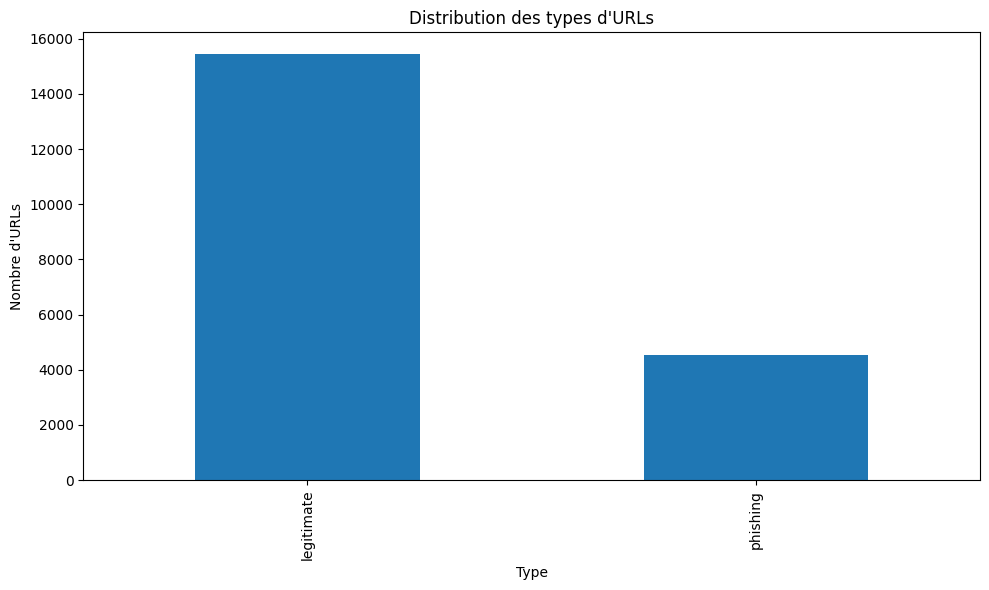

In [91]:
plt.figure(figsize=(10, 6))
df['type'].value_counts().plot(kind='bar')
plt.title('Distribution des types d\'URLs')
plt.xlabel('Type')
plt.ylabel('Nombre d\'URLs')
plt.tight_layout()
plt.show()

Extraction de caractéristiques simples

In [92]:
def extract_features(url):
    features = {}
    features['url_length'] = len(url)
    features['num_digits'] = sum(c.isdigit() for c in url)
    features['has_https'] = 1 if 'https' in url else 0
    features['num_special_chars'] = len(re.findall(r'[@_!#$%^&*()<>?/\|}{~:]', url))
    return features

Appliquer l'extraction à toutes les URLs

In [93]:
df_features = df['url'].apply(lambda x: extract_features(x))
df_features = pd.DataFrame(df_features.tolist())

In [94]:
df_features.head()

,url_length,num_digits,has_https,num_special_chars
0,133,25,0,8
1,35,0,1,6
2,80,8,1,5
3,67,0,1,5
4,43,0,1,5


Vectorisation du texte des URLs

In [95]:
vectorizer = TfidfVectorizer()
X_text_features = vectorizer.fit_transform(df['url'])

In [ ]:
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

In [96]:
X_text_features.shape

(20000, 41158)

In [97]:
# Conversion en tableau pour affichage
#X_array = X_text_features.toarray()


In [98]:
# Récupérer les mots du vocabulaire
#feature_names = vectorizer.get_feature_names_out()

In [99]:
# Affichage sous forme de DataFrame pour mieux visualiser
#df_tfidf = pd.DataFrame(X_array, columns=feature_names)

Concaténation des features

In [100]:
df_final = hstack([df_features, X_text_features])

In [101]:
df_final

<COOrdinate sparse matrix of dtype 'float64'
	with 231874 stored elements and shape (20000, 41162)>

In [102]:
#df_final = pd.concat([df_features, pd.DataFrame(X_text_features.toarray())], axis=1)

Encodage de la cible

In [103]:
df['type'] = df['type'].map({'legitimate': 0, 'phishing': 1})

Séparation des données

In [104]:
X_train, X_test, y_train, y_test = train_test_split(df_final, df['type'], test_size=0.2, random_state=42)

In [105]:
X_train.shape, y_train.shape, X_test.shape

((16000, 41162), (16000,), (4000, 41162))

Entraînement du modèle

In [106]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Évaluation

In [107]:
def evaluate(model, nome_model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    # cv = ShuffleSplit(5, test_size=0.2)
    cv = StratifiedKFold(5)
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=cv, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train_score')
    plt.plot(N, val_score.mean(axis=1), label='val_score')
    plt.title(nome_model)
    plt.xlabel('Training Size')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.show()

In [ ]:
# Sauvegarder le modèle et le scaler
joblib.dump(clf, 'clf.pkl')

['clf.pkl']

[[3054    0]
 [  17  929]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3054
           1       1.00      0.98      0.99       946

    accuracy                           1.00      4000
   macro avg       1.00      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000



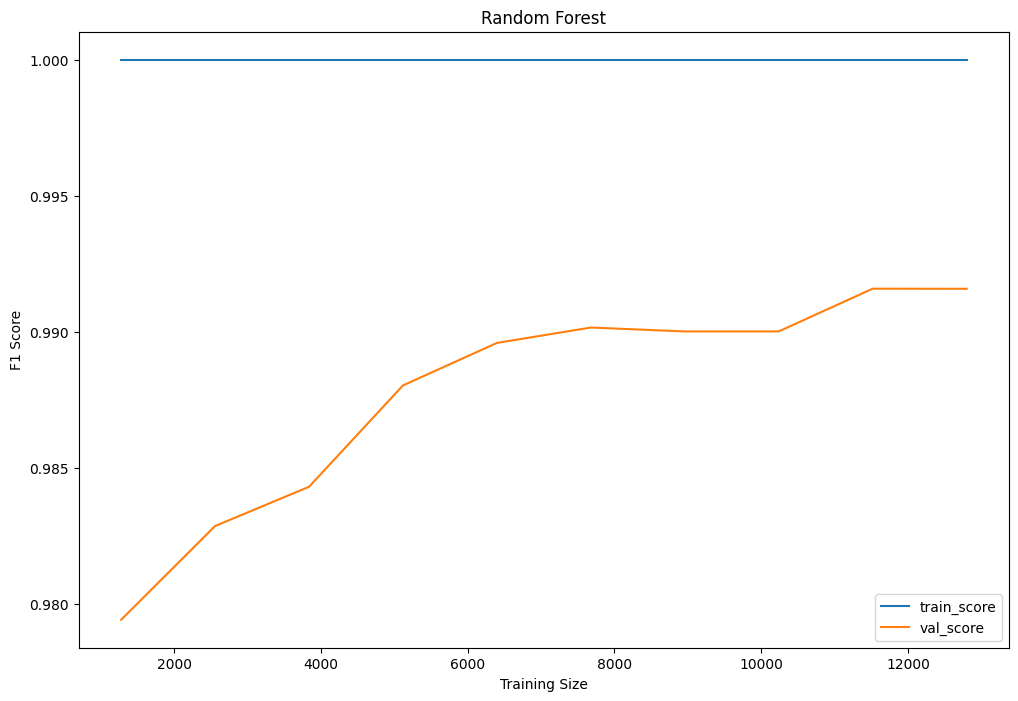

In [109]:
evaluate(clf, 'Random Forest')

In [110]:
y_pred = clf.predict(X_test)
print("Accuracy :", accuracy_score(y_test, y_pred))

Accuracy : 0.99575


In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3054
           1       1.00      0.98      0.99       946

    accuracy                           1.00      4000
   macro avg       1.00      0.99      0.99      4000
weighted avg       1.00      1.00      1.00      4000

